Loading Training data.

---


Removing few special characters.

In [ ]:
import numpy as np
import pandas as pd
import os
data = []
target = []
f = open("/content/drive/MyDrive/dataset/nlp_train_dataset.txt", "r")
rowtext = []
rowtarget = []
for line in f:
  if line == "\n":
    data.append(rowtext)
    target.append(rowtarget)
    rowtext = []
    rowtarget = []
  else:
    s=line.split()
    if s[0]!="." and s[0]!=",":
      rowtext.append(s[0])
    if s[1]!="." and s[1]!=",":
      rowtarget.append(s[1])
print(data[0])

['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', 'due', 'for', 'release', 'tomorrow', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits']


In [ ]:
df = pd.DataFrame(columns=["text","target"])
df["text"] = data
df["target"] = target

In [ ]:
df.head()

,text,target
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,..."
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,..."
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,..."
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T..."
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,..."


In [ ]:
print(len(df["text"][0]))
print(len(df["target"][0]))

34
34


In [ ]:
for i in range(len(df["text"].head(1)[0])):
  print(df["text"].head(1)[0][i] + "||"+ df["target"].head(1)[0][i])

Confidence||NN
in||IN
the||DT
pound||NN
is||VBZ
widely||RB
expected||VBN
to||TO
take||VB
another||DT
sharp||JJ
dive||NN
if||IN
trade||NN
figures||NNS
for||IN
September||NNP
due||JJ
for||IN
release||NN
tomorrow||NN
fail||VB
to||TO
show||VB
a||DT
substantial||JJ
improvement||NN
from||IN
July||NNP
and||CC
August||NNP
's||POS
near-record||JJ
deficits||NNS


In [ ]:
import gensim
w2v_model = gensim.models.Word2Vec(df["text"], size=100, window=5, min_count=1, workers=4)

X = np.zeros((len(df["text"]), 100))
for i, sentence in enumerate(df["text"]):
    for word in sentence:
        X[i] += w2v_model.wv[word]
    X[i] /= len(sentence)

Creating dictionary of Features

In [ ]:
unique_targets = []
for i in target:
  for j in i:
    if j not in unique_targets:
      unique_targets.append(j)

In [ ]:
print(unique_targets)

['NN', 'IN', 'DT', 'VBZ', 'RB', 'VBN', 'TO', 'VB', 'JJ', 'NNS', 'NNP', 'CC', 'POS', 'VBP', 'VBG', 'PRP$', 'CD', '``', "''", 'VBD', 'EX', 'MD', '#', '(', '$', ')', 'NNPS', 'PRP', 'JJS', 'WP', 'RBR', 'JJR', 'WDT', 'WRB', 'RBS', 'PDT', 'RP', ':', 'FW', 'WP$', 'SYM', 'UH']


In [ ]:
tag_to_id = {}
k = 0
for i in unique_targets:
  tag_to_id[i] = k
  k+=1
print(tag_to_id)

{'NN': 0, 'IN': 1, 'DT': 2, 'VBZ': 3, 'RB': 4, 'VBN': 5, 'TO': 6, 'VB': 7, 'JJ': 8, 'NNS': 9, 'NNP': 10, 'CC': 11, 'POS': 12, 'VBP': 13, 'VBG': 14, 'PRP$': 15, 'CD': 16, '``': 17, "''": 18, 'VBD': 19, 'EX': 20, 'MD': 21, '#': 22, '(': 23, '$': 24, ')': 25, 'NNPS': 26, 'PRP': 27, 'JJS': 28, 'WP': 29, 'RBR': 30, 'JJR': 31, 'WDT': 32, 'WRB': 33, 'RBS': 34, 'PDT': 35, 'RP': 36, ':': 37, 'FW': 38, 'WP$': 39, 'SYM': 40, 'UH': 41}


In [ ]:
y = np.zeros((len(df["target"]), len(tag_to_id)))
for i, pos_tag in enumerate(df["target"]):
    for tag in pos_tag:
        y[i, tag_to_id[tag]] = 1

In [ ]:
maxlength = 0
for i in df["text"]:
  if len(i)>maxlength:
    maxlength = len(i)
print(maxlength)

73


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

Padding

---


Training and Testing data split

In [ ]:
X_padded = pad_sequences(X, maxlen=maxlength, padding="post", truncating="post")
Y_padded = pad_sequences(y, maxlen=maxlength, padding="post", truncating="post")

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_padded,Y_padded,test_size=0.3, random_state=0, shuffle=True)

RNN Model

In [ ]:
GLOVE_DIR = "/content/drive/MyDrive/dataset/glove.6B.300d.txt"  # path to pre-trained GloVe embeddings
EMBEDDING_DIM = 300

embeddings_index = {}
with open(GLOVE_DIR) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
VALIDATION_SPLIT = 0.2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df["text"])
sequences = tokenizer.texts_to_sequences(df["text"])

word_index = tokenizer.word_index

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(df["target"])
Y_encoded = tag_tokenizer.texts_to_sequences(df["target"])



X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding="post")


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print("Embeddings shape: {}".format(embedding_matrix.shape))

Embeddings shape: (17257, 300)


In [ ]:
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y_padded)

In [ ]:
np.shape(Y)

(8936, 100, 43)

In [ ]:
NUM_CLASSES = Y.shape[2]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_padded,Y,test_size=0.2, random_state=0, shuffle=True)

In [ ]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(x_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("TESTING DATA")
print('Shape of input sequences: {}'.format(x_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (7148, 100)
Shape of output sequences: (7148, 100, 43)
TESTING DATA
Shape of input sequences: (1788, 100)
Shape of output sequences: (1788, 100, 43)


In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, SimpleRNN, TimeDistributed, RNN, GRU, Bidirectional
from tensorflow.keras.models import Sequential
rnn_model = Sequential()
rnn_model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation="softmax")))
rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(rnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         5177100   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 64)          23360     
                                                                 
 time_distributed_4 (TimeDis  (None, None, 43)         2795      
 tributed)                                                       
                                                                 
Total params: 5,203,255
Trainable params: 26,155
Non-trainable params: 5,177,100
_________________________________________________________________
None


In [ ]:
history = rnn_model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=128)

Epoch 1/30
45/45 [==============================] - 6s 95ms/step - loss: 1.7404 - accuracy: 0.6843 - val_loss: 0.6870 - val_accuracy: 0.8274
Epoch 2/30
45/45 [==============================] - 4s 96ms/step - loss: 0.6432 - accuracy: 0.8336 - val_loss: 0.6145 - val_accuracy: 0.8370
Epoch 3/30
45/45 [==============================] - 6s 141ms/step - loss: 0.5920 - accuracy: 0.8425 - val_loss: 0.5793 - val_accuracy: 0.8441
Epoch 4/30
45/45 [==============================] - 4s 96ms/step - loss: 0.5606 - accuracy: 0.8496 - val_loss: 0.5527 - val_accuracy: 0.8514
Epoch 5/30
45/45 [==============================] - 4s 95ms/step - loss: 0.5366 - accuracy: 0.8554 - val_loss: 0.5320 - val_accuracy: 0.8553
Epoch 6/30
45/45 [==============================] - 7s 156ms/step - loss: 0.5179 - accuracy: 0.8589 - val_loss: 0.5165 - val_accuracy: 0.8584
Epoch 7/30
45/45 [==============================] - 5s 119ms/step - loss: 0.5035 - accuracy: 0.8617 - val_loss: 0.5044 - val_accuracy: 0.8609
Epoch 8/30

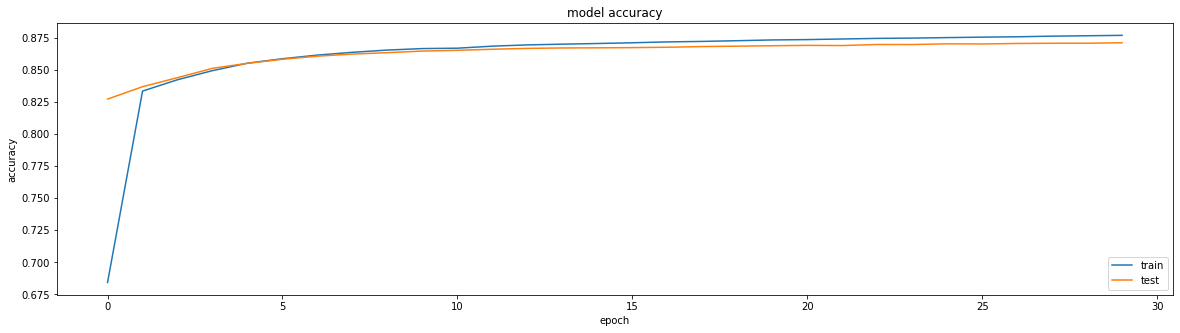

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

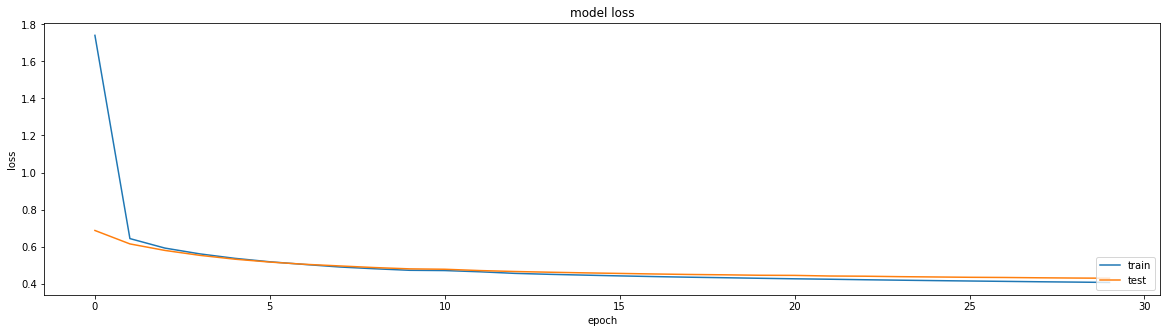

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

LSTM Model

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         5177100   
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          93440     
                                                                 
 time_distributed_5 (TimeDis  (None, None, 43)         2795      
 tributed)                                                       
                                                                 
Total params: 5,273,335
Trainable params: 5,273,335
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_training = lstm_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
45/45 [==============================] - 9s 150ms/step - loss: 1.6588 - accuracy: 0.7818 - val_loss: 0.6953 - val_accuracy: 0.8207
Epoch 2/10
45/45 [==============================] - 5s 106ms/step - loss: 0.6447 - accuracy: 0.8327 - val_loss: 0.6144 - val_accuracy: 0.8394
Epoch 3/10
45/45 [==============================] - 3s 66ms/step - loss: 0.5791 - accuracy: 0.8480 - val_loss: 0.5584 - val_accuracy: 0.8524
Epoch 4/10
45/45 [==============================] - 4s 85ms/step - loss: 0.5261 - accuracy: 0.8587 - val_loss: 0.5126 - val_accuracy: 0.8626
Epoch 5/10
45/45 [==============================] - 2s 48ms/step - loss: 0.4826 - accuracy: 0.8681 - val_loss: 0.4777 - val_accuracy: 0.8683
Epoch 6/10
45/45 [==============================] - 2s 48ms/step - loss: 0.4488 - accuracy: 0.8745 - val_loss: 0.4526 - val_accuracy: 0.8721
Epoch 7/10
45/45 [==============================] - 2s 36ms/step - loss: 0.4230 - accuracy: 0.8790 - val_loss: 0.4356 - val_accuracy: 0.8744
Epoch 8/10


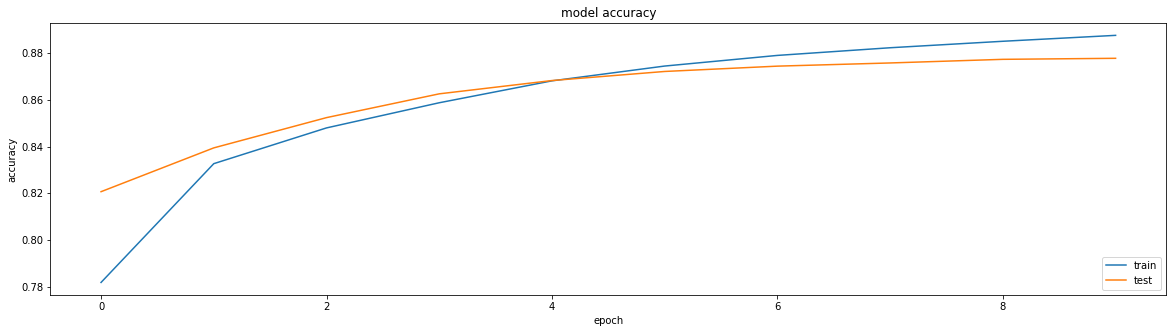

In [ ]:
from matplotlib import pyplot as plt
plt.plot(lstm_training.history['accuracy'])
plt.plot(lstm_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

GRU Model

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
gru_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         5177100   
                                                                 
 gru_1 (GRU)                 (None, None, 64)          70272     
                                                                 
 time_distributed_6 (TimeDis  (None, None, 43)         2795      
 tributed)                                                       
                                                                 
Total params: 5,250,167
Trainable params: 5,250,167
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_training = gru_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.3)

Epoch 1/10
40/40 [==============================] - 8s 125ms/step - loss: 1.9687 - accuracy: 0.8108 - val_loss: 0.6532 - val_accuracy: 0.8322
Epoch 2/10
40/40 [==============================] - 3s 87ms/step - loss: 0.6057 - accuracy: 0.8392 - val_loss: 0.5679 - val_accuracy: 0.8476
Epoch 3/10
40/40 [==============================] - 4s 102ms/step - loss: 0.5403 - accuracy: 0.8551 - val_loss: 0.5178 - val_accuracy: 0.8609
Epoch 4/10
40/40 [==============================] - 4s 105ms/step - loss: 0.4942 - accuracy: 0.8663 - val_loss: 0.4802 - val_accuracy: 0.8685
Epoch 5/10
40/40 [==============================] - 2s 50ms/step - loss: 0.4590 - accuracy: 0.8726 - val_loss: 0.4517 - val_accuracy: 0.8728
Epoch 6/10
40/40 [==============================] - 2s 53ms/step - loss: 0.4318 - accuracy: 0.8764 - val_loss: 0.4302 - val_accuracy: 0.8758
Epoch 7/10
40/40 [==============================] - 1s 28ms/step - loss: 0.4094 - accuracy: 0.8798 - val_loss: 0.4132 - val_accuracy: 0.8787
Epoch 8/10

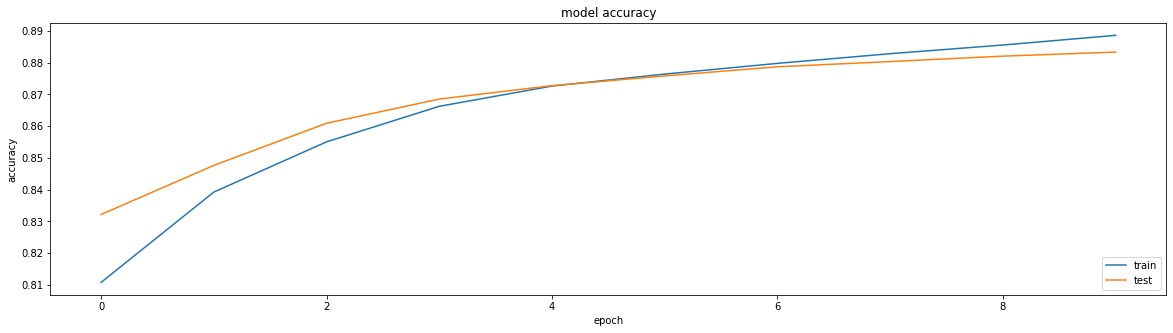

In [ ]:
from matplotlib import pyplot as plt
plt.plot(gru_training.history['accuracy'])
plt.plot(gru_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

Bidirectional LSTM Model

In [ ]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
bidirect_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
bidirect_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 300)         5177100   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        186880    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, None, 43)         5547      
 tributed)                                                       
                                                                 
Total params: 5,369,527
Trainable params: 5,369,527
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bidirect_training = bidirect_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.3)

Epoch 1/10
40/40 [==============================] - 11s 188ms/step - loss: 1.6345 - accuracy: 0.7923 - val_loss: 0.6408 - val_accuracy: 0.8312
Epoch 2/10
40/40 [==============================] - 4s 104ms/step - loss: 0.6060 - accuracy: 0.8368 - val_loss: 0.5737 - val_accuracy: 0.8448
Epoch 3/10
40/40 [==============================] - 3s 66ms/step - loss: 0.5459 - accuracy: 0.8510 - val_loss: 0.5227 - val_accuracy: 0.8580
Epoch 4/10
40/40 [==============================] - 3s 63ms/step - loss: 0.4982 - accuracy: 0.8644 - val_loss: 0.4836 - val_accuracy: 0.8680
Epoch 5/10
40/40 [==============================] - 2s 54ms/step - loss: 0.4612 - accuracy: 0.8726 - val_loss: 0.4550 - val_accuracy: 0.8735
Epoch 6/10
40/40 [==============================] - 2s 63ms/step - loss: 0.4331 - accuracy: 0.8777 - val_loss: 0.4347 - val_accuracy: 0.8766
Epoch 7/10
40/40 [==============================] - 2s 56ms/step - loss: 0.4107 - accuracy: 0.8812 - val_loss: 0.4189 - val_accuracy: 0.8789
Epoch 8/10

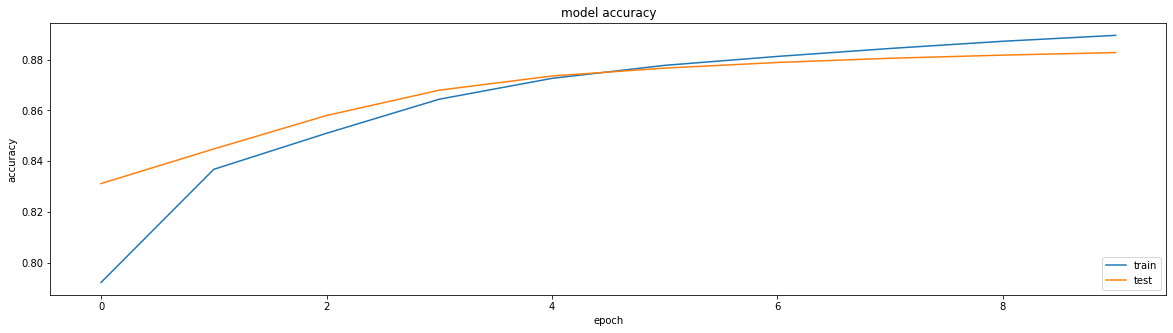

In [ ]:
from matplotlib import pyplot as plt
plt.plot(bidirect_training.history['accuracy'])
plt.plot(bidirect_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

Models Evaluation

In [ ]:
results = rnn_model.evaluate(x_test, y_test, batch_size=128,verbose=0)
print(rnn_model.metrics_names)
print(results)

['loss', 'accuracy']
[0.4288860261440277, 0.8723210096359253]


In [ ]:
results = lstm_model.evaluate(x_test, y_test, batch_size=128,verbose=0)
print(lstm_model.metrics_names)
print(results)

['loss', 'accuracy']
[0.40334591269493103, 0.8780201077461243]


In [ ]:
results = gru_model.evaluate(x_test, y_test, batch_size=128,verbose=0)
print(lstm_model.metrics_names)
print(results)

['loss', 'accuracy']
[0.3817194402217865, 0.882315456867218]


In [ ]:
results = bidirect_model.evaluate(x_test, y_test, batch_size=128,verbose=0)
print(bidirect_model.metrics_names)
print(results)

['loss', 'accuracy']
[0.3943280279636383, 0.8821252584457397]


Predict the test data

In [ ]:
import numpy as np
import pandas as pd
import os
test_data = []
f = open("/content/drive/MyDrive/dataset/nlp_test_dataset.txt", "r")
rowtext = []
for line in f:
  if line == "\n":
    test_data.append(rowtext)
    rowtext = []
  else:
    if line!='.\n' and line!=',\n':
      rowtext.append(line.strip('\n'))
print(test_data[0])

['Rockwell', 'International', 'Corp.', "'s", 'Tulsa', 'unit', 'said', 'it', 'signed', 'a', 'tentative', 'agreement', 'extending', 'its', 'contract', 'with', 'Boeing', 'Co.', 'to', 'provide', 'structural', 'parts', 'for', 'Boeing', "'s", '747', 'jetliners']


In [ ]:
test_df = pd.DataFrame(columns=["text"])
test_df["text"] = test_data

In [ ]:
test_df.head()

,text
0,"[Rockwell, International, Corp., 's, Tulsa, un..."
1,"[Rockwell, said, the, agreement, calls, for, i..."
2,"[These, include, among, other, parts, each, je..."
3,"[Under, the, existing, contract, Rockwell, sai..."
4,"[Rockwell, based, in, El, Segundo, Calif., is,..."


In [ ]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(test_df["text"])
sequences = []
for i in range(len(test_data)):
  sequence = tokenizer.texts_to_sequences([test_data[i]])
  sequences.append(sequence[0])
print(sequences[0])
print(sequences[30])
test_X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
#tag_tokenizer.word_index['<PAD>'] = 0
tag_tokenizer.index_word[0] = '<PAD>'

[1353, 270, 86, 8, 3413, 232, 14, 18, 917, 4, 2270, 432, 3414, 26, 307, 24, 1093, 101, 2, 433, 3415, 918, 7, 1093, 8, 3416, 3417]
[17, 82, 8, 335, 3, 70, 18, 21, 581, 7, 4, 3471, 10, 3472, 22]


In [ ]:
rnn_output = rnn_model.predict(test_X_padded)
rnn_pred_sequences = []
for i in range(len(rnn_output)):
    pred_tags = [tag_tokenizer.index_word[np.argmax(p)] for p in rnn_output[i]]
    rnn_pred_sequences.append(pred_tags)
for i in range(5):
  print(test_df.iloc[i])
  print(rnn_pred_sequences[i])
  print("\n")

63/63 [==============================] - 1s 10ms/step
text    [Rockwell, International, Corp., 's, Tulsa, un...
Name: 0, dtype: object
['vbg', 'nn', 'nn', 'pos', 'nnp', 'nn', 'vbd', 'in', 'jj', 'dt', 'nn', 'nn', 'nn', 'vbp', 'vbp', 'in', 'in', 'in', 'in', 'in', 'in', 'nnp', 'in', 'nn', 'nn', 'prp$', 'jj', 'nn', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


text    [Rockwell, said, the, agreeme

In [ ]:
lstm_output = lstm_model.predict(test_X_padded)
lstm_pred_sequences = []
for i in range(len(lstm_output)):
    pred_tags = [tag_tokenizer.index_word[np.argmax(p)] for p in lstm_output[i]]
    lstm_pred_sequences.append(pred_tags)
for i in range(5):
  print(test_df.iloc[i])
  print(len(test_df.iloc[i]))
  print(lstm_pred_sequences[i])
  print(len(lstm_pred_sequences[i]))
  print("\n")

63/63 [==============================] - 0s 4ms/step
text    [Rockwell, International, Corp., 's, Tulsa, un...
Name: 0, dtype: object
1
['vbn', 'nn', 'nn', 'pos', 'nnp', 'vbn', 'vbd', 'in', 'in', 'dt', 'dt', 'dt', 'nn', 'vbp', 'nn', 'in', 'in', 'nnp', 'in', 'in', 'in', 'nn', 'in', 'in', 'pos', 'nns', 'nn', 'nn', 'nn', 'nn', 'nn', 'nn', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
100


text    [Rockwell, said, the, agreement, cal

In [ ]:
print(len(test_data))
print(len(test_data[0]))
print(len(sequences))
print(len(sequences[0]))
print(len(test_X_padded))
print(len(test_X_padded[0]))

print(len(rnn_output))
print(len(rnn_output[0]))
print(len(lstm_pred_sequences))
print(len(lstm_pred_sequences[0]))

2012
27
2012
27
2012
100
2012
100
2012
100


In [ ]:
gru_output = gru_model.predict(test_X_padded)
gru_pred_sequences = []
for i in range(len(gru_output)):
    pred_tags = [tag_tokenizer.index_word[np.argmax(p)] for p in gru_output[i]]
    gru_pred_sequences.append(pred_tags)
for i in range(5):
  print(test_df.iloc[i])
  print(len(test_df.iloc[i]))
  print(gru_pred_sequences[i])
  print(len(gru_pred_sequences[i]))
  print("\n")

63/63 [==============================] - 0s 3ms/step
text    [Rockwell, International, Corp., 's, Tulsa, un...
Name: 0, dtype: object
1
['vbn', 'nn', '(', 'pos', 'nnp', 'vbn', 'vbd', 'vbd', 'vbd', 'dt', 'dt', 'nn', 'nn', 'vbp', 'nnp', 'in', 'vbn', 'nnp', 'nnp', 'nn', 'nnp', 'nn', 'in', 'in', 'pos', 'pos', 'nn', 'nn', 'nn', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
100


text    [Rockwell, said, the, 

In [ ]:
bidirect_output = bidirect_model.predict(test_X_padded)
bidirect_pred_sequences = []
for i in range(len(bidirect_output)):
    pred_tags = [tag_tokenizer.index_word[np.argmax(p)] for p in bidirect_output[i]]
    bidirect_pred_sequences.append(pred_tags)
for i in range(5):
  print(test_df.iloc[i])
  print(len(test_df.iloc[i]))
  print(bidirect_pred_sequences[i])
  print(len(bidirect_pred_sequences[i]))
  print("\n")

63/63 [==============================] - 1s 5ms/step
text    [Rockwell, International, Corp., 's, Tulsa, un...
Name: 0, dtype: object
1
['vbd', 'nn', 'nnp', 'pos', 'nnp', 'vbn', 'vbd', 'in', 'rb', 'dt', 'dt', 'dt', 'nn', 'vbp', 'nnp', 'in', 'vbn', 'nnp', 'in', 'in', 'in', 'nn', 'in', 'in', 'pos', 'in', 'nn', 'nn', 'nn', 'nn', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
100


text    [Rockwell, said, the, agreem

Writing to file

In [ ]:
nr = len(test_data)
with open('/content/drive/MyDrive/dataset/labeled_test_dataset_lstm.txt', 'w') as f:
  for i in range(nr):
    nc = len(test_data[i])
    for j in range(nc):
      if test_data[i][j]!="<PAD>":
        f.write(str(test_data[i][j])+" " + str(lstm_pred_sequences[i][j] ))
        f.write("\n")

In [ ]:
nr = len(test_data)
with open('/content/drive/MyDrive/dataset/labeled_test_dataset_rnn.txt', 'w') as f:
  for i in range(nr):
    nc = len(test_data[i])
    for j in range(nc):
      if test_data[i][j]!="<PAD>":
        f.write(str(test_data[i][j])+" " + str(rnn_pred_sequences[i][j] ))
        f.write("\n")

In [ ]:
nr = len(test_data)
with open('/content/drive/MyDrive/dataset/labeled_test_dataset_gru.txt', 'w') as f:
  for i in range(nr):
    nc = len(test_data[i])
    for j in range(nc):
      if test_data[i][j]!="<PAD>":
        f.write(str(test_data[i][j])+" " + str(gru_pred_sequences[i][j] ))
        f.write("\n")

In [ ]:
nr = len(test_data)
with open('/content/drive/MyDrive/dataset/labeled_test_dataset_bidirect.txt', 'w') as f:
  for i in range(nr):
    nc = len(test_data[i])
    for j in range(nc):
      if test_data[i][j]!="<PAD>":
        f.write(str(test_data[i][j])+" " + str(bidirect_pred_sequences[i][j] ))
        f.write("\n")

In [ ]:
lstm = {}
rnn = {}
bidirect = {}
gru = {}
hmm = {}
logistic = {}

for i in tag_to_id.keys():
  lstm[i.lower()] = 0
  rnn[i.lower()] = 0
  bidirect[i.lower()] = 0
  gru[i.lower()] = 0
  hmm[i.lower()] = 0
  logistic[i.lower()] = 0

file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_lstm.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n")
  if tag in lstm.keys():
    lstm[tag]+=1


file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_rnn.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n")
  if tag in rnn.keys():
    rnn[tag]+=1


file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_gru.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n")
  if tag in gru.keys():
    gru[tag]+=1


file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_bidirect.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n")
  if tag in bidirect.keys():
    bidirect[tag]+=1

    
waste = []
for i in lstm.keys():
  if lstm[i]<100:
    waste.append(i)
for i in waste:
  del lstm[i]
  del bidirect[i]
  del rnn[i]
  del gru[i]
  del hmm[i]
  del logistic[i]

print(rnn)
print(lstm)
print(gru)
print(bidirect)

{'nn': 8220, 'in': 6849, 'dt': 4618, 'vbz': 867, 'rb': 1180, 'vbn': 682, 'to': 1461, 'vb': 758, 'jj': 2148, 'nns': 2812, 'nnp': 3922, 'cc': 1420, 'pos': 387, 'vbp': 291, 'vbg': 120, 'prp$': 371, 'cd': 1310, '``': 295, "''": 264, 'vbd': 1371, 'md': 426, '$': 335, 'prp': 693, ':': 152}
{'nn': 7866, 'in': 6412, 'dt': 4632, 'vbz': 709, 'rb': 1192, 'vbn': 417, 'to': 1114, 'vb': 658, 'jj': 2783, 'nns': 3337, 'nnp': 3949, 'cc': 1756, 'pos': 402, 'vbp': 481, 'vbg': 203, 'prp$': 406, 'cd': 1671, '``': 329, "''": 214, 'vbd': 1540, 'md': 365, '$': 327, 'prp': 796, ':': 127}
{'nn': 7028, 'in': 6637, 'dt': 4744, 'vbz': 793, 'rb': 1398, 'vbn': 633, 'to': 1566, 'vb': 647, 'jj': 2181, 'nns': 2812, 'nnp': 4103, 'cc': 1456, 'pos': 436, 'vbp': 468, 'vbg': 34, 'prp$': 422, 'cd': 1707, '``': 325, "''": 320, 'vbd': 1515, 'md': 430, '$': 447, 'prp': 927, ':': 117}
{'nn': 7911, 'in': 6801, 'dt': 4442, 'vbz': 758, 'rb': 1388, 'vbn': 620, 'to': 1185, 'vb': 641, 'jj': 2757, 'nns': 2845, 'nnp': 3906, 'cc': 1239, 

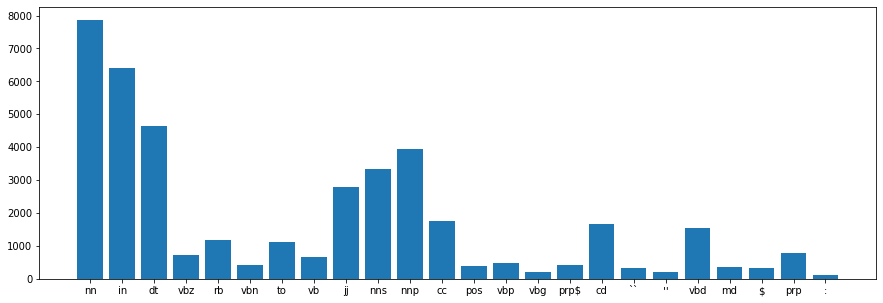

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.bar(range(len(lstm)), lstm.values(), tick_label=lstm.keys())
plt.xticks(range(len(lstm)), list(lstm.keys()))
plt.show()

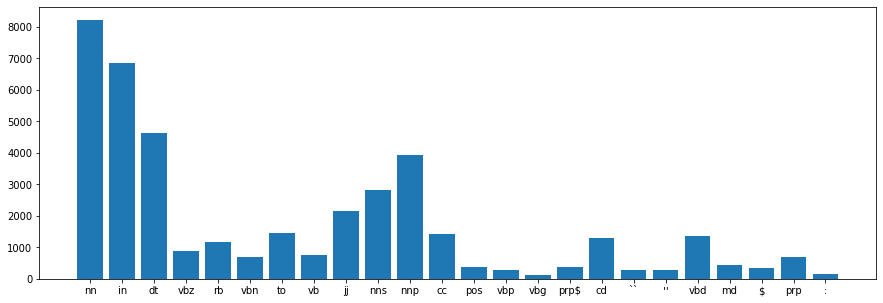

In [ ]:
plt.bar(range(len(rnn)), rnn.values(), tick_label=rnn.keys())
plt.xticks(range(len(rnn)), list(rnn.keys()))
plt.show()

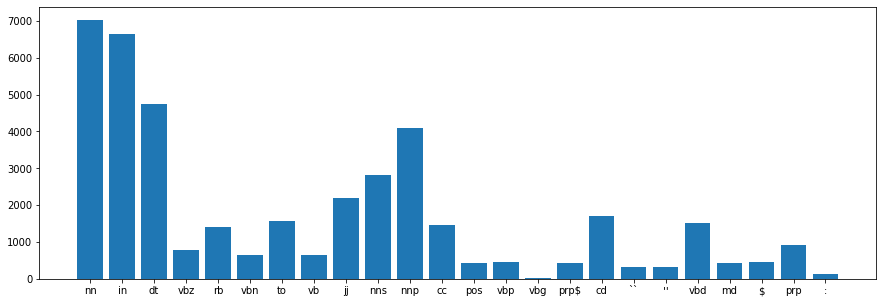

In [ ]:
plt.bar(range(len(gru)), gru.values(), tick_label=gru.keys())
plt.xticks(range(len(gru)), list(gru.keys()))
plt.show()

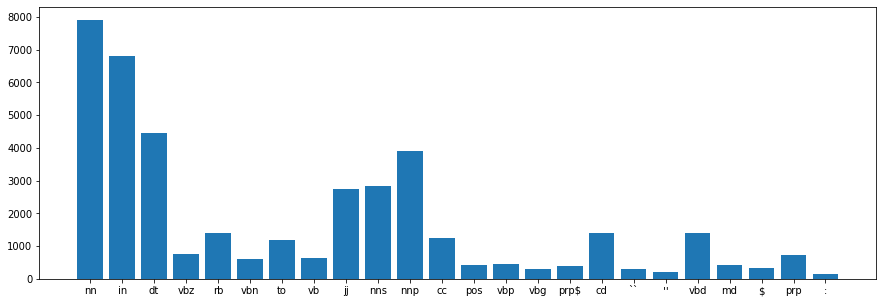

In [ ]:
plt.bar(range(len(bidirect)), bidirect.values(), tick_label=bidirect.keys())
plt.xticks(range(len(bidirect)), list(bidirect.keys()))
plt.show()

In [ ]:
file1 = open('/content/drive/MyDrive/dataset/labeled_test_data_hmm.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n").lower()
  if tag in hmm.keys():
    hmm[tag]+=1
print(hmm)

{'nn': 4851, 'in': 5008, 'dt': 3193, 'vbz': 730, 'rb': 1042, 'vbn': 758, 'to': 784, 'vb': 903, 'jj': 2032, 'nns': 2074, 'nnp': 3676, 'cc': 826, 'pos': 330, 'vbp': 416, 'vbg': 483, 'prp$': 323, 'cd': 1111, '``': 257, "''": 240, 'vbd': 1142, 'md': 356, '$': 316, 'prp': 648, ':': 140}


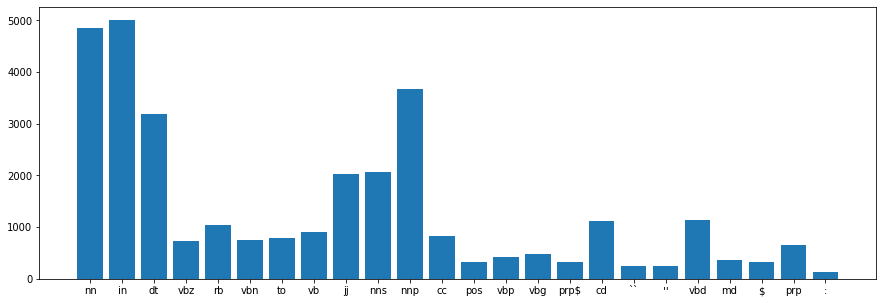

In [ ]:
plt.bar(range(len(hmm)), hmm.values(), tick_label=hmm.keys())
plt.xticks(range(len(hmm)), list(hmm.keys()))
plt.show()

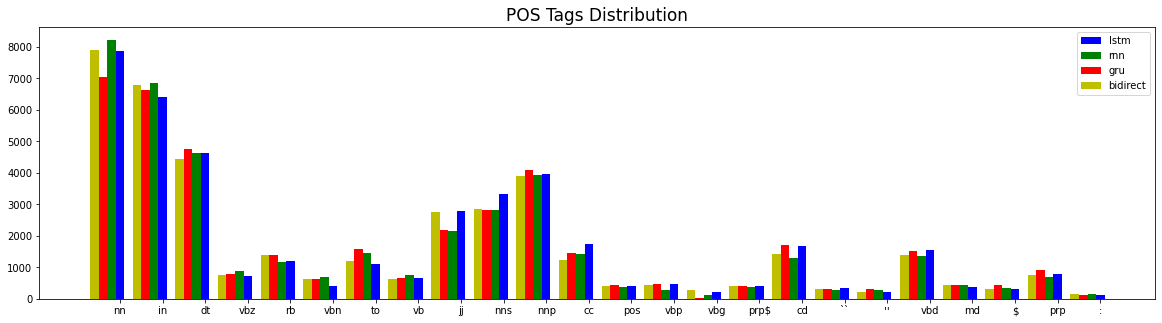

In [ ]:
X = np.arange(len(lstm))
plt.rcParams["figure.figsize"] = (20,5)
ax = plt.subplot(111)

ax.bar(X, lstm.values(), width=0.2, color='b', align='center')
ax.bar(X-0.2, rnn.values(), width=0.2, color='g', align='center')
ax.bar(X-0.4, gru.values(), width=0.2, color='r', align='center')
ax.bar(X-0.6, bidirect.values(), width=0.2, color='y', align='center')

ax.legend(('lstm','rnn','gru','bidirect', 'hmm'))
plt.xticks(X, lstm.keys())
plt.title("POS Tags Distribution", fontsize=17)
plt.show()

In [ ]:
file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_logistic.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n").lower()
  if tag in logistic.keys():
    logistic[tag]+=1
print(logistic)

{'nn': 5232, 'in': 15299, 'dt': 4493, 'vbz': 0, 'rb': 0, 'vbn': 0, 'to': 0, 'vb': 0, 'jj': 0, 'nns': 0, 'nnp': 4254, 'cc': 2357, 'pos': 0, 'vbp': 0, 'vbg': 0, 'prp$': 0, 'cd': 0, '``': 6963, "''": 0, 'vbd': 0, 'md': 0, '$': 0, 'prp': 0, ':': 0}


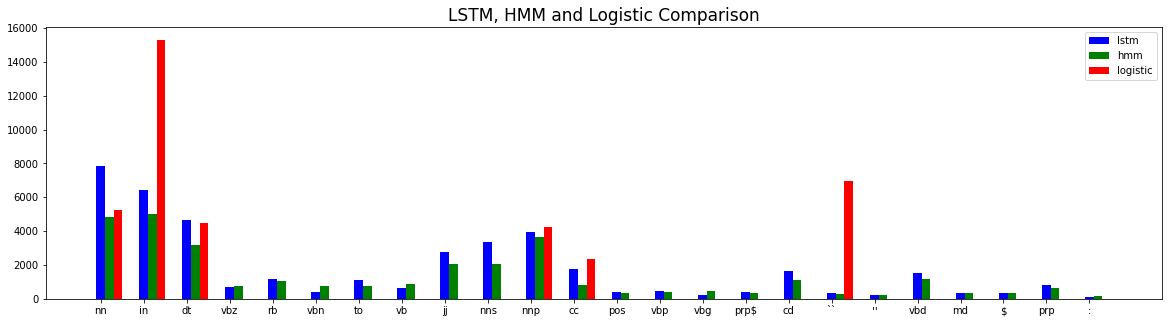

In [ ]:
X = np.arange(len(lstm))
plt.rcParams["figure.figsize"] = (20,5)
ax = plt.subplot(111)

ax.bar(X, lstm.values(), width=0.2, color='b', align='center')
ax.bar(X+0.2, hmm.values(), width=0.2, color='g', align='center')
ax.bar(X+0.4, logistic.values(), width=0.2, color='r', align='center')

ax.legend(('lstm', 'hmm', 'logistic'))
plt.xticks(X, lstm.keys())
plt.title("LSTM, HMM and Logistic Comparison", fontsize=17)
plt.show()